In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import plotly.express as px
import mapclassify

In [2]:
cdmx_gdp=gpd.read_file('data/shapes/09m.shp')

In [3]:
gam_gdp=cdmx_gdp[cdmx_gdp['CVE_MUN']=='005']
gam_gdp.head()

,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,geometry
13705,09,005,0001,1148,008,Típica,"POLYGON ((2802682.728 835673.649, 2802672.945 ..."
13706,09,005,0001,1152,018,Típica,"POLYGON ((2803015.393 835770.018, 2802994.766 ..."
13707,09,005,0001,1148,010,Típica,"POLYGON ((2802748.907 835754.125, 2802780.251 ..."
13708,09,005,0001,1148,007,Típica,"POLYGON ((2802668.317 835705.970, 2802677.191 ..."
13709,09,005,0001,1148,012,Típica,"POLYGON ((2802934.098 835634.631, 2802880.177 ..."


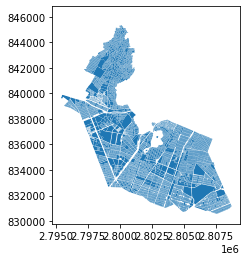

In [4]:
gam_gdp.plot()

In [5]:
gam_data=pd.read_csv('data/GM_coords.csv')
#gam_data = gam_data.loc[:400]
gam_data.head(1)

,Unnamed: 0,Status,m2,State,Rooms,Price,Adress,lon,lat
0,0,Casa en venta,200,construidos,3 recs.,2300000,"Gustavo A. Madero , Distrito Federal",-99.123613,19.487333


In [6]:
gam_data.drop(columns=['Unnamed: 0'],inplace=True)
gam_data['Price_m2']=gam_data['Price']/gam_data['m2']

In [7]:
## Making lat & lon as geometry
gam_geometry =[Point(xy) for xy in zip(gam_data['lon'],gam_data['lat'])]
gam_crs={'init':'epsg:4326'}
gam_points_gpd=gpd.GeoDataFrame(gam_data,crs=gam_crs,geometry=gam_geometry)

In [8]:
gam_points_gpd.head(1)

,Status,m2,State,Rooms,Price,Adress,lon,lat,Price_m2,geometry
0,Casa en venta,200,construidos,3 recs.,2300000,"Gustavo A. Madero , Distrito Federal",-99.123613,19.487333,11500.0,POINT (-99.12361 19.48733)


In [9]:
#We have to check if the Coordinate reference system (CRS) of both geodataframes are equal, if not, we have to set the equal
gam_points_gpd.crs

{'init': 'epsg:4326'}

In [10]:
# Changing CRS in GAM
gam_gdp = gam_gdp.to_crs({'init': 'epsg:4326'})
gam_gdp.crs

{'init': 'epsg:4326'}

In [11]:
points_with_gdp=sjoin(gam_points_gpd,gam_gdp,how='left')

In [12]:
bounderies=gam_gdp.geometry.bounds

In [13]:
list(bounderies)

['minx', 'miny', 'maxx', 'maxy']

In [14]:
min_x=bounderies['minx'].min()
min_y=bounderies['miny'].min()
max_x=bounderies['maxx'].max()
max_y=bounderies['maxy'].max()

In [15]:
points_with_gdp
cl=(~points_with_gdp['CVE_ENT'].isna())

points_with_gdp=points_with_gdp[cl]

In [16]:
points_with_gdp
points_with_gdp['id']=points_with_gdp['CVE_MUN']+points_with_gdp['CVE_LOC']+points_with_gdp['CVE_AGEB']+points_with_gdp['CVE_MZA']

In [17]:
points_with_gdp
cl=(points_with_gdp['lat']>max_y)|(points_with_gdp['lat']<min_y)|(points_with_gdp['lon']>max_x)|(points_with_gdp['lon']<min_x)
points_with_gdp=points_with_gdp[~cl]

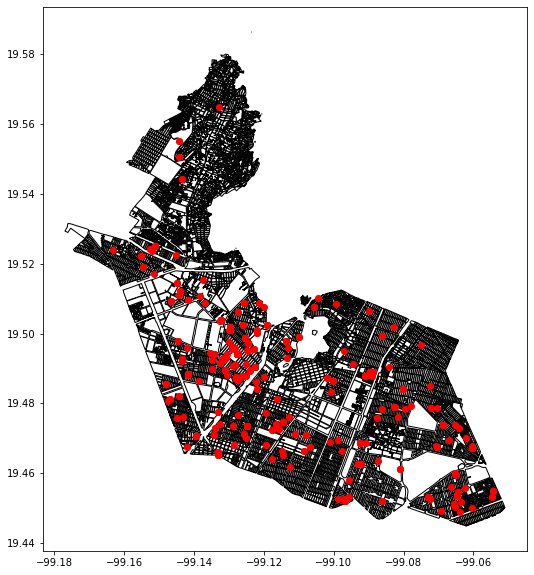

In [18]:
ax = gam_gdp.plot(figsize=(10, 10), color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
points_with_gdp.plot(ax=ax, color='red')
#plt.savefig('gam.png', transparent=True)
plt.show()

In [19]:
points_with_gdp.head(1)
# **********
points_with_gdp['Price_m2']=points_with_gdp['Price']/points_with_gdp['m2']

In [20]:
list(points_with_gdp)

['Status',
 'm2',
 'State',
 'Rooms',
 'Price',
 'Adress',
 'lon',
 'lat',
 'Price_m2',
 'geometry',
 'index_right',
 'CVE_ENT',
 'CVE_MUN',
 'CVE_LOC',
 'CVE_AGEB',
 'CVE_MZA',
 'TIPOMZA',
 'id']

In [21]:
points_with_gdp.head(1)

,Status,m2,State,Rooms,Price,Adress,lon,lat,Price_m2,geometry,index_right,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,id
3,Casa en venta,160,construidos,3 recs.,1499000,"641 227 , San Juan De Aragón 4a Secc. , Gusta...",-99.065156,19.459747,9368.75,POINT (-99.06516 19.45975),20437.0,09,005,0001,2377,007,Típica,00500012377007


In [22]:
#Loading Alcaldias attribures
attr=pd.read_csv('variables_and_percents/GM_10_20.csv')

C:\Users\Wayssen\anaconda3\envs\pythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



In [23]:
attr.head(1)

,Unnamed: 0,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,...,pct_0a2,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int
0,0,2010,Distrito Federal,5,1,0012,0,4312,212.0,370.0,...,4.916512,8.580705,32.38842,96.352313,99.55516,95.907473,0.44484,27.935943,25.266904,16.192171


In [24]:
def zero_plus(item,digits):
    i=str(item)
    zeros=digits-len(i)
    return zeros*'0'+i

In [25]:
attr['mun']=[zero_plus(i,3) for i in attr['mun']]
attr['loc']=[zero_plus(i,4) for i in attr['loc']]
attr['ageb']=[zero_plus(i,4) for i in attr['ageb']]
attr['mza']=[zero_plus(i,3) for i in attr['mza']]

In [26]:
# Choosing 005 for GAM
attr['id']='005'+attr['loc']+attr['ageb']+attr['mza']

In [27]:
attr.tail(2)

,Unnamed: 0,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,...,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int,id
16576,16576,2020,Ciudad de MÃ©xico,005,0001,3445,038,32,NaN,0.0,...,0.000000,38.461538,90.000000,100.0,90.000000,0.0,30.000000,NaN,60.000000,00500013445038
16577,16577,2020,Ciudad de MÃ©xico,005,0001,3445,039,87,3.0,5.0,...,5.747126,36.956522,96.153846,100.0,96.153846,NaN,26.923077,23.076923,57.692308,00500013445039


In [28]:
# Merge metros cubicos attributes and INEGI attributes
price_mz=points_with_gdp[['id','Price_m2']].groupby('id',as_index=False).mean()
price_mz.head(2)
attr.head(2)

,Unnamed: 0,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,...,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int,id
0,0,2010,Distrito Federal,005,0001,0012,000,4312,212.0,370.0,...,8.580705,32.388420,96.352313,99.55516,95.907473,0.44484,27.935943,25.266904,16.192171,00500010012000
1,1,2010,Distrito Federal,005,0001,0012,001,174,9.0,13.0,...,7.471264,34.328358,NaN,NaN,NaN,NaN,34.883721,27.906977,13.953488,00500010012001


In [33]:
data=price_mz[['id','Price_m2']].merge(attr,on='id',how='left')

In [34]:
data.head(2)

,id,Price_m2,Unnamed: 0,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,...,pct_0a2,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int
0,00500010101014,747.556351,190.0,2010.0,Distrito Federal,005,0001,0101,014,151.0,...,5.960265,10.596026,23.076923,NaN,NaN,NaN,NaN,28.947368,31.578947,18.421053
1,00500010101014,747.556351,8479.0,2020.0,Ciudad de MÃ©xico,005,0001,0101,014,129.0,...,NaN,13.953488,36.065574,100.0,100.0,100.0,0.0,26.315789,18.421053,52.631579


In [35]:
data.drop(columns=['nom_ent',
                   'Unnamed: 0',
                   'nom_ent',
                   'mun',
                   'loc',
                   'ageb',
                   'mza'],inplace=True)

In [36]:
data.to_csv('data/GAM_to_model.csv',index=False)